<a href="https://colab.research.google.com/github/GaoangLiu/ipynb/blob/master/Quora_Insincere_Questions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load packages 
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api


In [0]:
# Get data
! rm *.csv
! wget -O quora.zip bwg.140714.xyz:8000/quora.zip 
! unzip quora.zip 
! ls 

In [0]:
# Base class for classifier
class Classifier():
  def __init__(self):
    self.train = None
    self.test = None 
    self.model = None

  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
  
  def countvectorize(self):
      tv = TfidfVectorizer(ngram_range=(1,3), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=5000)
      tv = CountVectorizer()
      tv.fit(self.train.question_text)
      self.vector_train = tv.transform(self.train.question_text)
      self.vector_test  = tv.transform(self.test.question_text)
      logging.info("Train & test text tokenized")

  def build_model(self):
      pass

  def run_model(self):
      # Choose your own classifier: self.model and run it
      logging.info(f"{self.__class__.__name__} starts running.")
      labels = self.train.target
      x_train, x_val, y_train, y_val = train_test_split(self.vector_train, labels, test_size=0.2, random_state=2090)
      self.model.fit(x_train, y_train)
      y_preds = self.model.predict(x_val)

      logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
      logging.info(f"Confusion matrix: ") 
      print(confusion_matrix(y_val, y_preds))
      print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))
      # y_preds = self.model.predict(self.vector_test)
      return y_preds

  def save_predictions(self, y_preds):
      sub = pd.read_csv(f"sample_submission.csv")
      sub['prediction'] = y_preds 
      sub.to_csv(f"submission_{self.__class__.__name__}.csv", index=False)
      logging.info('Prediction exported to submisison.csv')
  
  def pipeline(self):
      s_time = time.clock()
      self.load_data()
      self.countvectorize()
      self.build_model()
      self.save_predictions(self.run_model())
      logging.info(f"Program running for {time.clock() - s_time} seconds")

class C_Bayes(Classifier):
  def build_model(self):
      self.model = MultinomialNB()
      return self.model

# Logistic Regression 
class C_LR(Classifier):
  def build_model(self):
      self.model = LogisticRegression(n_jobs=10, solver='lbfgs', C=0.1, verbose=1)
      return self.model

class C_SVM(Classifier):
  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.train = self.train.sample(100000)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')

  def build_model(self):
      self.model = svm.SVC()
      return self.model

class C_Ensemble(Classifier):
  def ensemble(self):
      s_time = time.perf_counter()
      self.load_data()
      self.countvectorize()

      nb = MultinomialNB()
      lr = LogisticRegression(n_jobs=10, solver='saga', C=0.1, verbose=1)
      svc = svm.SVC()

      all_preds = [0] * self.test.shape[0]
      for m in (nb, lr, svc):
          self.model = m
          if m == svc: 
              self.load_data()
              self.train = self.train.sample(10000)
              self.countvectorize()
          all_preds += self.run_model()

      all_preds = [1 if p > 0 else 0 for p in all_preds]
      self.save_predictions(all_preds)
      logging.info(f"Program running for {time.perf_counter() - s_time} seconds")


class Helper():
    def locate_threshold(self, model, x_val, y_val):
        y_probs = model.predict(x_val, batch_size=1024, verbose=1)
        best_threshold = best_f1 = pre_f1 = 0
        history = []

        for i in np.arange(0.01, 1, 0.01):
          if len(y_probs[0]) >= 2:
              y2_preds = [1 if e[1] >= i else 0 for e in y_probs]
          else:
              y2_preds = (y_probs > i).astype(int)

          cur_f1 = f1_score(y_val, y2_preds)
          history.append((i, cur_f1))
          symbol = '+' if cur_f1 >= pre_f1 else '-'
          print("Threshold {:6.4f}, f1_score: {:<0.8f}  {} {:<0.6f} ".format(i, cur_f1, symbol, abs(cur_f1 - pre_f1)))
          pre_f1 = cur_f1

          if cur_f1 >= best_f1:
              best_f1 = cur_f1
              best_threshold = i

        print(f"Best f1 score {best_f1}, best threshold {best_threshold}")
        plt.xlabel('Threshold')
        plt.ylabel('f1_score')
        plt.plot(*zip(*history))

## CNN
We've tried linear models, the best result of private`f1_score` we got is 0.62166. Now we try Neural Network

2020.05.11 

* Biderectional GRU achieved `private_score` 0.64255, `public_score` 0.63140

Seems that, smaller `batch_size` produces better performance, both on `precision` and `f1_score` .

2020.05.12 Keras API GRU. 

* YES !!!! Finally reach `private_score=0.65443` and `public_score=0.63905` with Bidrectional GRU `max_features=50000, embed_size=300, max_len=100`




In [22]:
class C_NN(Classifier):
    def __init__(self, max_features=100000, embed_size=128, max_len=300):
        self.max_features=max_features
        self.embed_size=embed_size
        self.max_len=max_len
    
    def tokenize_text(self, text_train, text_test):
        '''@para: max_features, the most commenly used words in data set
        @input are vector of text
        '''
        tokenizer = Tokenizer(num_words=self.max_features)
        text = pd.concat([text_train, text_test])
        tokenizer.fit_on_texts(text)

        sequence_train = tokenizer.texts_to_sequences(text_train)
        tokenized_train = pad_sequences(sequence_train, maxlen=self.max_len)
        logging.info('Train text tokeninzed')

        sequence_test = tokenizer.texts_to_sequences(text_test)
        tokenized_test = pad_sequences(sequence_test, maxlen=self.max_len)
        logging.info('Test text tokeninzed')
        return tokenized_train, tokenized_test, tokenizer
      
    def build_model(self):
        dropout = 0.2
        model = Sequential()
        model.add(Embedding(self.max_features, self.embed_size, input_length=self.max_len))
        model.add(Bidirectional(GRU(64, return_sequences=True)))
        model.add(Bidirectional(GRU(64, return_sequences=True)))
        model.add(Flatten())

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(1, activation='sigmoid'))
        self.model = model

        return self.model
        
    def embed_word_vector(self, word_index, model='glove-wiki-gigaword-100'):
        glove = api.load(model) # default: wikipedia 6B tokens, uncased
        zeros = [0] * self.embed_size
        matrix = np.zeros((self.max_features, self.embed_size))
          
        for word, i in word_index.items(): 
            if i >= self.max_features or word not in glove: continue # matrix[0] is zeros, that's also why >= is here
            matrix[i] = glove[word]

        logging.info('Matrix with embedded word vector created')
        return matrix

    def run(self, x_train, y_train):
        checkpoint = ModelCheckpoint('weights_base_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_acc", mode="max", patience=5)

        self.model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
        X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=2020)
        BATCH_SIZE = max(16, 2 ** int(math.log(len(X_tra) / 100, 2)))
        logging.info(f"Batch size is set to {BATCH_SIZE}")
        history = self.model.fit(X_tra, y_tra, epochs=2, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), \
                              callbacks=[checkpoint, early], verbose=1)

        y_pred = self.model.predict(X_val, batch_size=64, verbose=1)
        y_pred_bool = np.argmax(y_pred, axis=1)
        print(classification_report(y_val, y_pred_bool))
        return history

class C_GRU():
    def __init__(self):
        self.embed_size=300
        self.max_features=50000
        self.max_len=200
    
    def build_model(self, embed_matrix=[]):
        text_input = Input(shape=(self.max_len, ))
        embed_text = layers.Embedding(self.max_features, self.embed_size)(text_input)
        if len(embed_matrix) > 0:
            embed_text = layers.Embedding(self.max_features, self.embed_size, \
                                          weights=[embed_matrix], trainable=False)(text_input)
            

        branch_a = layers.Bidirectional(layers.GRU(64, return_sequences=True))(embed_text)
        branch_b = layers.GlobalMaxPool1D()(branch_a)
        branch_c = layers.Dense(64, activation='relu')(branch_b)
        branch_d = layers.Dropout(0.1)(branch_c)
        branch_z = layers.Dense(1, activation='sigmoid')(branch_d)
        
        model = Model(inputs=text_input, outputs=branch_z)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model

c = C_NN(max_features=50000, embed_size=300, max_len=200)
c.load_data()
# # c.train = c.train[:300_000]
vector_train, vector_test, tokenizer = c.tokenize_text(c.train.question_text, c.test.question_text)
matrix = c.embed_word_vector(tokenizer.word_index, model='word2vec-google-news-300')
model = C_GRU().build_model(matrix)

# model.get_weights()

[05-13 02:20:39     INFO] CSV data loaded
[05-13 02:21:34     INFO] Train text tokeninzed
[05-13 02:21:42     INFO] Test text tokeninzed


[=================================================-] 98.9% 1644.0/1662.8MB downloaded


[05-13 02:24:45     INFO] word2vec-google-news-300 downloaded
[05-13 02:24:45     INFO] loading projection weights from /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
[05-13 02:26:21     INFO] loaded (3000000, 300) matrix from /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
[05-13 02:26:21     INFO] Matrix with embedded word vector created


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
X_tra, X_val, y_tra, y_val = train_test_split(vector_train, c.train.target, train_size=0.8, random_state=2020)
history = model.fit(X_tra, y_tra, epochs=1, batch_size=256, validation_data=(X_val, y_val))

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 2807s 3ms/step - loss: 0.1197 - acc: 0.9539 - val_loss: 0.1088 - val_acc: 0.9569


261225/261225 [==============================] - 17s 66us/step
Threshold 0.0100, f1_score: 0.30196804  + 0.301968 
Threshold 0.0200, f1_score: 0.37718462  + 0.075217 
Threshold 0.0300, f1_score: 0.42460487  + 0.047420 
Threshold 0.0400, f1_score: 0.45828618  + 0.033681 
Threshold 0.0500, f1_score: 0.48417174  + 0.025886 
Threshold 0.0600, f1_score: 0.50518665  + 0.021015 
Threshold 0.0700, f1_score: 0.52308516  + 0.017899 
Threshold 0.0800, f1_score: 0.53743841  + 0.014353 
Threshold 0.0900, f1_score: 0.55049877  + 0.013060 
Threshold 0.1000, f1_score: 0.56138344  + 0.010885 
Threshold 0.1100, f1_score: 0.57100616  + 0.009623 
Threshold 0.1200, f1_score: 0.57996602  + 0.008960 
Threshold 0.1300, f1_score: 0.58795589  + 0.007990 
Threshold 0.1400, f1_score: 0.59426371  + 0.006308 
Threshold 0.1500, f1_score: 0.59944496  + 0.005181 
Threshold 0.1600, f1_score: 0.60555069  + 0.006106 
Threshold 0.1700, f1_score: 0.61132162  + 0.005771 
Threshold 0.1800, f1_score: 0.61607702  + 0.004755 
T

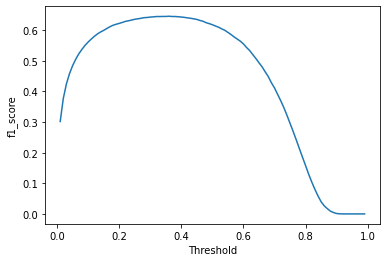

In [24]:
# Find maximum threshold 
Helper().locate_threshold(model, X_val, y_val)
# 300_000 train size, batch_size = 1024, f1_score = 0.6118
# 300_000 train size, batch_size = 1024, double GRU, f1_score = 0.6113
# 300_000 train size, batch_size = 1024, with glove-wiki-gigaword-100 embeding, f1_score = 0.6030
# 300_000 train size, batch_size = 1024, with google-news 300 embeding, f1_score = 0.6078
# full train, bsize 1024, embed_size=300, maxlen=200, google news 300, f1_score = 0.6404
# full train, bsize 1024, embed_size=300, maxlen=200, no embed, f1_score = 0.6390

# Keras API full train, Bidirectional GRU 64, bsize 256, embed_size 300, maxlen 200, no embed, f1_score 0.6485
# Keras API full train, Bidirectional GRU 64, bsize 256, embed_size 300, maxlen 200, fasttext 300, f1_score 0.6417
# Keras API full train, Bidirectional GRU 64, bsize 256, embed_size 300, maxlen 200, google news 300, f1_score 0.6456

# FYI, pretrained word vectors are not always winning

# Logistic Regression 
Besides NB, we also tried LR to maximum `f1_score`

2020.05.09: 
* Set `threshold = 0.21`, we got public score 0.60627 + private score = 0.62161. Bot are the maximum score we've got by now.
<img class="center" src="https://i.loli.net/2020/05/09/eE4KqloW52FDSdc.png" alt="LR max f1_score" width=850>
* Set `threshold=0.25`, `public_score=0.60619` decreased, but `private_score=0.62166` increased. 


In [0]:
c = C_LR()
c.load_data()
# b.train = b.train.sample(100000)
c.countvectorize()
labels = c.train.target
x_train, x_val, y_train, y_val = train_test_split(c.vector_train, labels, test_size=0.2, random_state=2090)

model = LogisticRegression(n_jobs=10, solver='saga', C=0.1, verbose=1)
model.fit(x_train, y_train)
y_preds = model.predict(x_val)

print(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
print(f"Confusion matrix: ") 
print(confusion_matrix(y_val, y_preds))
print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))

In [0]:
# Find the best threshold to maximum f1_score
Helper().locate_threshold(model, x_val, y_val)


# Naive Bayes
Since in this contest submissions are evaluated on **F1 Score** between the predicted and the observed targets. Our ultimate goal is to maximum the `f1_socre`. 

2020.05.09: 
* Naive Bayes achieved the maximum score `f1_score = 0.56456695` when the `threshold` is set to `0.726`. This result in a public score = 0.56452 + private score = 0.56706. The public socre is the best we've got with NB, but the private score is only second to 0.56889, one when we set the `threshold` to 0.6 .



In [0]:
b = C_Bayes()
b.load_data()
b.countvectorize()
b.build_model()
labels = b.train.target
x_train, x_val, y_train, y_val = train_test_split(b.vector_train, labels, test_size=0.2, random_state=2090)
b.model.fit(x_train, y_train)
y_preds = b.model.predict(x_val)

logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
logging.info(f"Confusion matrix: ") 
print(confusion_matrix(y_val, y_preds))
print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))



In [0]:
# Find the best threshold to maximum f1_score
Helper().locate_threshold(b.model, x_val, y_val)